In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape, SpatialDropout2D
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [ ]:
import re
import glob
import numpy as np
from PIL import Image

numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

filelist_trainx = sorted(glob.glob('/content/drive/MyDrive/Project/skin/trainx/*.bmp'), key=numericalSort)

# **Resizing Images to (128,128)**
IMG_WIDTH = 224
IMG_HEIGHT = 224
X_train = np.array([np.array(Image.open(fname).resize((IMG_WIDTH, IMG_HEIGHT))) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/content/drive/MyDrive/Project/skin/trainy/*.bmp'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname).resize((IMG_WIDTH, IMG_HEIGHT))) for fname in filelist_trainy]) # Resizing trainy images as well


In [ ]:
filelist_trainx

['/content/drive/MyDrive/Project/skin/trainx/IMD002.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD003.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD004.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD006.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD008.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD009.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD010.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD013.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD014.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD015.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD016.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD017.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD018.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD019.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD020.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD021.bmp',
 '/content/drive/MyDrive/Project/skin/trainx/IMD022.bmp',
 '/content/dri

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

In [ ]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))

Length of the Training Set   : 150
Length of the Test Set       : 50


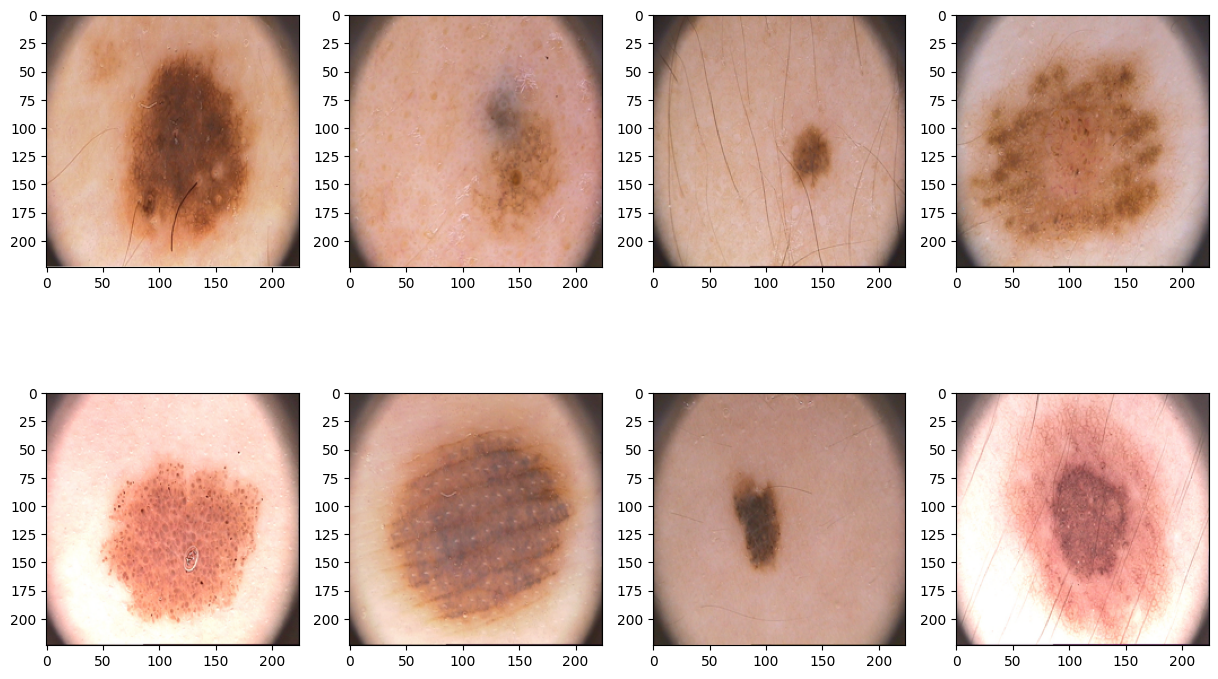

In [ ]:
plt.figure(figsize=(15,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [ ]:
def iou(y_true, y_pred, smooth = 100):
    y_true = K.cast(y_true, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    y_true = K.cast(y_true, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    y_true = K.cast(y_true, 'float32')
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [ ]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    y_true = K.cast(y_true, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [ ]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [ ]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

In [ ]:
# # Make sure to import necessary libraries
# import numpy as np
# from PIL import Image
# import glob
# import re
# import cv2
# from sklearn.model_selection import train_test_split

# # Define numericalSort function
# numbers = re.compile(r'(\d+)')
# def numericalSort(value):
#     parts = numbers.split(value)
#     parts[1::2] = map(int, parts[1::2])
#     return parts

# # Load and resize training images
# IMG_WIDTH = 128
# IMG_HEIGHT = 128

# filelist_trainx = sorted(glob.glob('/content/drive/MyDrive/Project/skin/trainx/*.bmp'), key=numericalSort)
# X_train = np.array([np.array(Image.open(fname).resize((IMG_WIDTH, IMG_HEIGHT))) for fname in filelist_trainx])

# filelist_trainy = sorted(glob.glob('/content/drive/MyDrive/Project/skin/trainy/*.bmp'), key=numericalSort)
# Y_train = np.array([np.array(Image.open(fname).resize((IMG_WIDTH, IMG_HEIGHT))) for fname in filelist_trainy])

# # Split the data into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=101)

# # Define augmentation functions
# def random_rotation(x_image, y_image):
#     rows_x,cols_x, chl_x = x_image.shape
#     rows_y,cols_y = y_image.shape
#     rand_num = np.random.randint(-40,40)
#     M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
#     M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
#     x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
#     y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
#     return x_image, y_image.astype('int')

# def horizontal_flip(x_image, y_image):
#     x_image = cv2.flip(x_image, 1)
#     y_image = cv2.flip(y_image.astype('float32'), 1)
#     return x_image, y_image.astype('int')

# # Define img_augmentation function
# def img_augmentation(x_train, y_train):
#     x_rotat = []
#     y_rotat = []
#     x_flip = []
#     y_flip = []
#     for idx in range(len(x_train)):
#         x,y = random_rotation(x_train[idx], y_train[idx])
#         x_rotat.append(x)
#         y_rotat.append(y)
#         x,y = horizontal_flip(x_train[idx], y_train[idx])
#         x_flip.append(x)
#         y_flip.append(y)
#     return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

# # Perform data augmentation
# x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

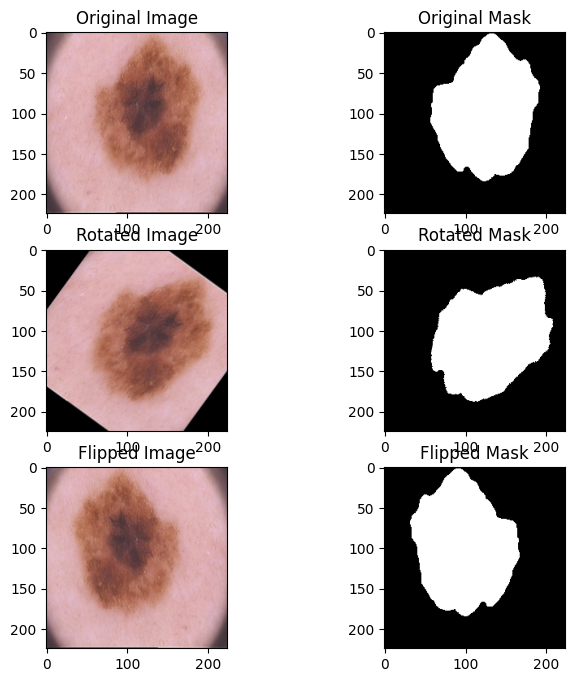

In [ ]:
img_num = 7
plt.figure(figsize=(8,8))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()


In [ ]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [ ]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 360
Length of the Test Set       : 50
Length of the Validation Set : 90


In [ ]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights


In [ ]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(learning_rate = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 32,validation_data=(x_val, y_val), verbose=1)
    model.save(savename)
    return model, hist

In [ ]:
model, hist = UNET_224(1, 'unet_1_epoch.h5')

Model: "UNET_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 224, 224, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 224, 224, 32)   │              0 │ activation_1[0][0]     │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ spatial_dropout2d[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 112, 112, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 112, 112, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_1       │ (None, 112, 112, 64)   │              0 │ activation_3[0][0]     │
│ (SpatialDropout2D)        │                        │                │                        │
├──────────────────────

 Total params: 31,466,753 (120.04 MB)

 Trainable params: 31,454,721 (119.99 MB)

 Non-trainable params: 12,032 (47.00 KB)

12/12 ━━━━━━━━━━━━━━━━━━━━ 971s 78s/step - accuracy: 0.6504 - dice_coe: 0.5435 - iou: 0.7527 - loss: 0.2473 - precision: 0.5259 - recall: 0.7748 - val_accuracy: 0.3129 - val_dice_coe: 0.4764 - val_iou: 0.5251 - val_loss: 0.4749 - val_precision: 0.3129 - val_recall: 1.0000


In [ ]:
dropout_val=0.50
if K.image_data_format() == 'channels_first':
    inputs = Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((224,224))(conv_final)


In [ ]:
model_0 = Model(inputs, pred, name="UNET_224")
model_0.compile(optimizer= Adam(learning_rate = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])


In [ ]:
model_0.load_weights('unet_1_epoch.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'unet_1_epoch.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:

print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

 1/20 ━━━━━━━━━━━━━━━━━━━━ 4:37 15s/step - accuracy: 0.6825 - dice_coe: 0.0177 - iou: 0.6711 - loss: 0.3289 - precision: 0.0099 - recall: 4.5544e-05

KeyboardInterrupt: 

In [ ]:
model, hist = UNET_224(epochs_num= 20, savename= 'unet_100_epoch.h5')

Model: "UNET_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 224, 224, 32)   │            128 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_23             │ (None, 224, 224, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 224, 224, 32)   │          9,248 │ activation_23[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 224, 224, 32)   │            128 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_24             │ (None, 224, 224, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_11      │ (None, 224, 224, 32)   │              0 │ activation_24[0][0]    │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 112, 112, 32)   │              0 │ spatial_dropout2d_11[… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 112, 112, 64)   │            256 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_25             │ (None, 112, 112, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ activation_25[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 112, 112, 64)   │            256 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_26        

 Total params: 31,466,753 (120.04 MB)

 Trainable params: 31,454,721 (119.99 MB)

 Non-trainable params: 12,032 (47.00 KB)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1060s 86s/step - accuracy: 0.6585 - dice_coe: 0.5431 - iou: 0.7518 - loss: 0.2482 - precision: 0.5453 - recall: 0.7764 - val_accuracy: 0.3129 - val_dice_coe: 0.4764 - val_iou: 0.5251 - val_loss: 0.4749 - val_precision: 0.3129 - val_recall: 1.0000
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 981s 81s/step - accuracy: 0.8731 - dice_coe: 0.6928 - iou: 0.8792 - loss: 0.1208 - precision: 0.8067 - recall: 0.7742 - val_accuracy: 0.3129 - val_dice_coe: 0.4764 - val_iou: 0.5251 - val_loss: 0.4749 - val_precision: 0.3129 - val_recall: 1.0000
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 966s 79s/step - accuracy: 0.9021 - dice_coe: 0.7506 - iou: 0.9030 - loss: 0.0970 - precision: 0.8760 - recall: 0.8135 - val_accuracy: 0.3129 - val_dice_coe: 0.4764 - val_iou: 0.5251 - val_loss: 0.4749 - val_precision: 0.3129 - val_recall: 1.0000
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 955s 80s/step - accuracy: 0.8996 - dice_coe: 0.7505 - iou: 0.9016 - loss: 0.0984 - precision: 0.8639 - recall

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

model_1.compile(
    optimizer=Adam(learning_rate=0.003),
    loss=[jaccard_distance],
    metrics=[iou, dice_coe, precision, recall, BinaryAccuracy()]
)

In [ ]:
model_1.load_weights('unet_100_epoch.h5')

In [ ]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100)) # Included Loss
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100)) # Included Loss
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100)) # Included Loss
print('________________________')

In [ ]:
plt.figure(figsize=(10, 10))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


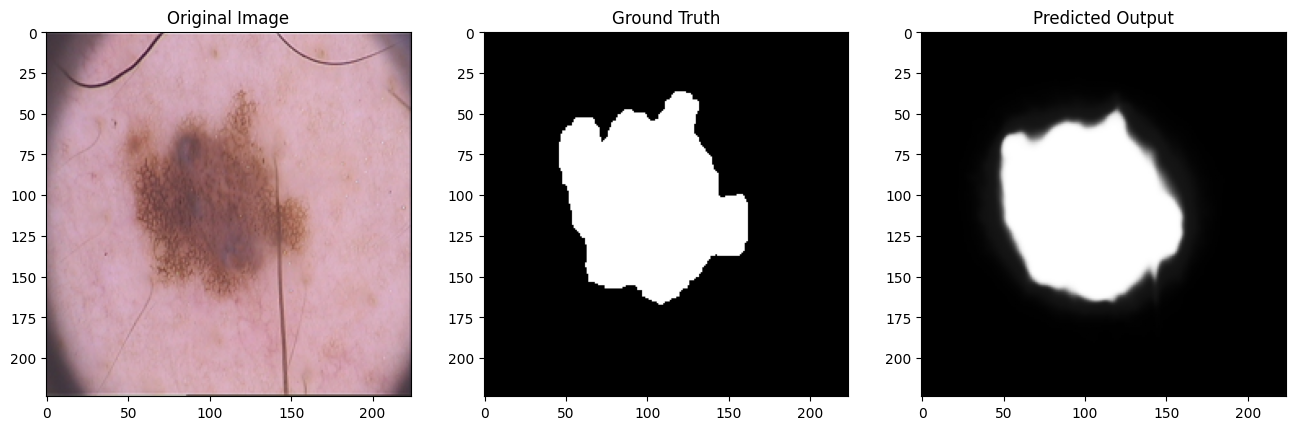

In [ ]:
img_num = 37
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


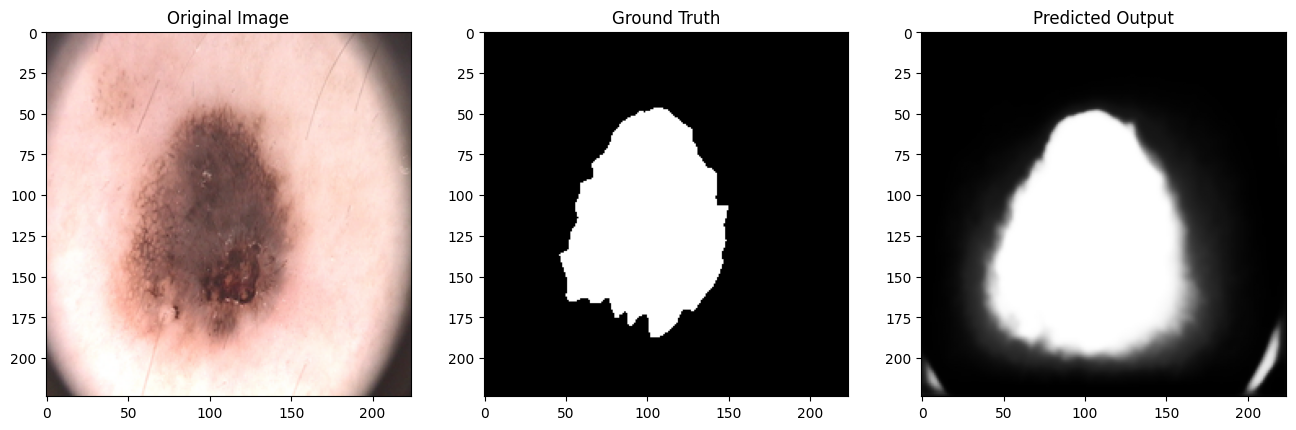

In [ ]:
img_num = 29
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


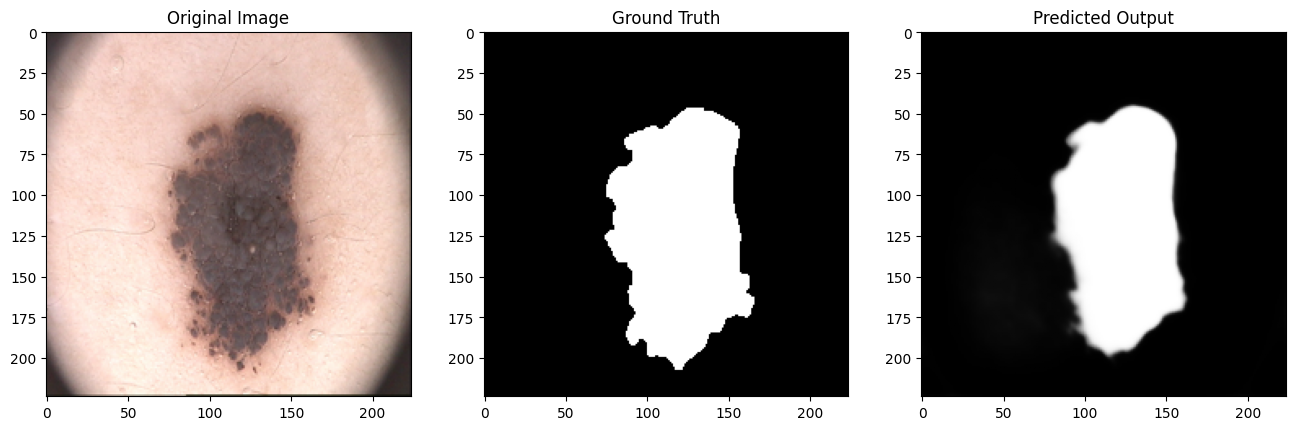

In [ ]:
img_num = 47
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()


In [ ]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


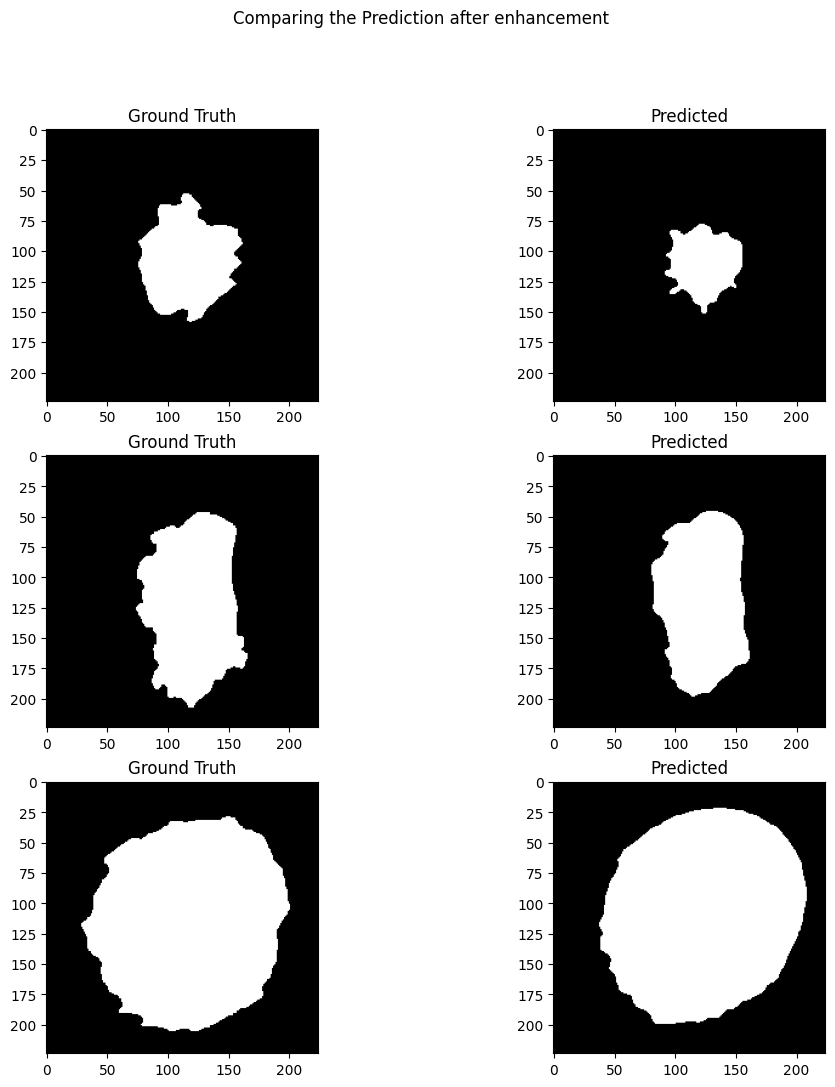

In [ ]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[48],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[48]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.show()